In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bplt
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.layouts import gridplot,row,column
from bokeh.io import output_notebook
from util.DaskProfileReader import *
from bokeh.charts import BoxPlot,Bar,Line,TimeSeries
from bokeh.models import Range1d, FixedTicker
from bokeh.models import CheckboxGroup, CustomJS

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
output_notebook()

Loading BokehJS ...

# Speedup
The next plot shows Dask'a execution of RMSD x600 speedup. The x-axis is the number of cores used and the y-axis is Speedup. The plot shows three lines. WIth green color, we show line y=x to denote linear speed up. With Red color we have the speedup of the Block RMSD tasks, as we increased the number of cores and essentially decreased the amount of data its task used for computation. The blue line is the speed up of the overall execution, including all dependencies and data transfers of the execution.

In [2]:
rmsd600 = pd.DataFrame(columns=['Block','Try','Task','Time'])
rmsd600Mean = pd.DataFrame(columns=['Tasks','Try','Time'])
block_size = [1,2,3,4,6,8,9,12,16,18,24,36,48,72,144]

for block in block_size:
    temp = pd.DataFrame(columns=['Block','Try','Task','Time'])
    data1 = DaskProfileReader('stragglers/iteration2/4node/stragglers_test_600_%d_1.txt'%(block))
    temp['Time']=data1[data1['name']=='block_rmsd']['duration'].values/1000
    temp['Task']=range(block)
    temp['Try']='Run 1'
    temp['Block']=block
    rmsd600Mean.loc[len(rmsd600Mean)]=[block,1,np.mean(data1[data1['name']=='block_rmsd']['duration'].values/1000)]
    rmsd600 = rmsd600.append(temp)
    temp = pd.DataFrame(columns=['Block','Try','Task','Time'])
    data2 = DaskProfileReader('stragglers/iteration2/4node/stragglers_test_600_%d_2.txt'%(block))
    temp['Time'] = data2[data2['name']=='block_rmsd']['duration'].values/1000
    temp['Task']=range(block)
    temp['Try']='Run 2'
    temp['Block']=block
    rmsd600Mean.loc[len(rmsd600Mean)]=[block,2,np.mean(data1[data1['name']=='block_rmsd']['duration'].values/1000)]
    rmsd600 = rmsd600.append(temp)
    temp = pd.DataFrame(columns=['Block','Try','Task','Time'])
    data3 = DaskProfileReader('stragglers/iteration2/4node/stragglers_test_600_%d_3.txt'%(block))
    temp['Time'] = data3[data3['name']=='block_rmsd']['duration'].values/1000
    temp['Task']=range(block)
    temp['Try']='Run 3'
    temp['Block']=block
    rmsd600Mean.loc[len(rmsd600Mean)]=[block,3,np.mean(data1[data1['name']=='block_rmsd']['duration'].values/1000)]
    rmsd600 = rmsd600.append(temp)
    temp = pd.DataFrame(columns=['Block','Try','Task','Time'])
    data4 = DaskProfileReader('stragglers/iteration2/4node/stragglers_test_600_%d_4.txt'%(block))
    temp['Time'] = data4[data4['name']=='block_rmsd']['duration'].values/1000
    temp['Task']=range(block)
    temp['Try']='Run 4'
    temp['Block']=block
    rmsd600Mean.loc[len(rmsd600Mean)]=[block,4,np.mean(data1[data1['name']=='block_rmsd']['duration'].values/1000)]
    rmsd600 = rmsd600.append(temp)
    temp = pd.DataFrame(columns=['Block','Try','Task','Time'])
    data5 = DaskProfileReader('stragglers/iteration2/4node/stragglers_test_600_%d_5.txt'%(block))
    temp['Time'] = data5[data5['name']=='block_rmsd']['duration'].values/1000
    temp['Task']=range(block)
    temp['Try']='Run 5'
    temp['Block']=block
    rmsd600Mean.loc[len(rmsd600Mean)]=[block,5,np.mean(data1[data1['name']=='block_rmsd']['duration'].values/1000)]
    rmsd600 = rmsd600.append(temp)

rmsd600=rmsd600.reset_index().drop('index',axis=1)
rmsd600Mean['Speedup']=1

data2 = (rmsd600Mean[rmsd600Mean['Try']==1]).reset_index()
data2['Speedup'] = data2['Time'][0]/data2['Time'].values
rmsd600Mean['Speedup'].loc[range(0,75,5)] = data2['Speedup'].values

data2 = (rmsd600Mean[rmsd600Mean['Try']==2]).reset_index()
data2['Speedup'] = data2['Time'][0]/data2['Time'].values
rmsd600Mean['Speedup'].loc[range(1,75,5)] = data2['Speedup'].values

data2 = (rmsd600Mean[rmsd600Mean['Try']==3]).reset_index()
data2['Speedup'] = data2['Time'][0]/data2['Time'].values
rmsd600Mean['Speedup'].loc[range(2,75,5)] = data2['Speedup'].values

data2 = (rmsd600Mean[rmsd600Mean['Try']==4]).reset_index()
data2['Speedup'] = data2['Time'][0]/data2['Time'].values
rmsd600Mean['Speedup'].loc[range(3,75,5)] = data2['Speedup'].values

data2 = (rmsd600Mean[rmsd600Mean['Try']==5]).reset_index()
data2['Speedup'] = data2['Time'][0]/data2['Time'].values
rmsd600Mean['Speedup'].loc[range(4,75,5)] = data2['Speedup'].values

def mda_data_reader(data_line):
    points = data_line.split()
    ret = [int(points[0].split('DCD')[1]),int(points[1]),int(points[2]),float(points[3]),float(points[4]),float(points[5]),float(points[6]),float(points[7])]
    return ret

dataFile = open('stragglers/iteration2/4node/data.txt')
df = pd.DataFrame(columns=['Size','Tasks','Run','T_Comp_Mean', 'T_Comp_Max', 'T_All_Frame_Mean', 'T_All_Frame_Max','Total Time'])
for line in dataFile.readlines():
    df.loc[len(df)]=mda_data_reader(line)
dataFile.close()


data = df[df['Size']==100]
data['Speedup']=1

data2 = (data[data['Run']==1]).reset_index()
data2['Speedup'] = data2['Total Time'][0]/data2['Total Time'].values
data['Speedup'].loc[range(0,75,5)] = data2['Speedup'].values

data2 = (data[data['Run']==2]).reset_index()
data2['Speedup'] = data2['Total Time'][0]/data2['Total Time'].values
data['Speedup'].loc[range(1,75,5)] = data2['Speedup'].values

data2 = (data[data['Run']==3]).reset_index()
data2['Speedup'] = data2['Total Time'][0]/data2['Total Time'].values
data['Speedup'].loc[range(2,75,5)] = data2['Speedup'].values

data2 = (data[data['Run']==4]).reset_index()
data2['Speedup'] = data2['Total Time'][0]/data2['Total Time'].values
data['Speedup'].loc[range(3,75,5)] = data2['Speedup'].values

data2 = (data[data['Run']==5]).reset_index()
data2['Speedup'] = data2['Total Time'][0]/data2['Total Time'].values
data['Speedup'].loc[range(4,75,5)] = data2['Speedup'].values



speedupTotalDF = pd.DataFrame(columns=['Tasks','Mean','Std'])
speedupTaskDF = pd.DataFrame(columns=['Tasks','Mean','Std'])
for i in range(0,75,5):
    speedupTotalDF.loc[i] = [(data['Tasks'].loc[range(i,i+5)]).mean(),(data['Speedup'].loc[range(i,i+5)]).mean(),(data['Speedup'].loc[range(i,i+5)]).std()]
    speedupTaskDF.loc[i] = [(rmsd600Mean['Tasks'].loc[range(i,i+5)]).mean(),(rmsd600Mean['Speedup'].loc[range(i,i+5)]).mean(),(rmsd600Mean['Speedup'].loc[range(i,i+5)]).std()]

p = bplt.figure(tools="pan,wheel_zoom,box_zoom,reset,save",plot_width=1000,plot_height=500,title='Speedup',x_axis_label = "Tasks",y_axis_label='Speedup',y_axis_type='log',x_axis_type='log')
CDS=ColumnDataSource(speedupTotalDF)
CDS2 = ColumnDataSource(speedupTaskDF)
p.line('Tasks','Mean',line_width=3,legend='TTC Speedup',source=CDS,color='blue')
p.circle('Tasks','Mean',line_width=4,legend='TTC Speedup',source=CDS,color='blue')
p.line('Tasks','Mean',line_width=2,legend='T_{x} Speedup',source=CDS2,color='red')
p.asterisk('Tasks','Mean',size=12,legend='T_{x} Speedup',source=CDS2,color='red')
p.line([1,100],[1,100],color='green')
p.xaxis.major_label_text_font = "14pt"
p.yaxis.major_label_text_font = "14pt"
p.xaxis.ticker = FixedTicker(ticks=block_size)
p.yaxis.ticker = FixedTicker(ticks=[1,2.5,5,10,20,40,50,55,60,70,80,90,100])
p.add_tools(HoverTool(point_policy="follow_mouse",
            tooltips="""
                <div>
                    <span style="font-size: 12px; font-weight: bold;">Tasks: @Tasks</span>
                    <span style="font-size: 12px; font-weight: bold;">Mean: @Mean</span>
                    <span style="font-size: 12px; font-weight: bold;">Std: @Std</span>
                </div>
            """
        ))
p.legend.location = "bottom_right"
bplt.show(p)

/Users/iparask/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/iparask/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/iparask/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/iparask/anac

# Histograms of different parts of RMSD Dask execution

In [3]:
rmsd600 = pd.DataFrame(columns=['Block','Try','Time'])
rmsd600everything = pd.DataFrame(columns=['action','alpha','color','duration','key', 'name','start','y','Run'])
block_size = [144]

for block in block_size:
    for i in range(1,40):
        temp = pd.DataFrame(columns=['Block','Try','Task','Time'])
        data1 = DaskProfileReader('stragglers/iteration2/4node_stat/stragglers_test_600_%d_%d.txt'%(block,i))
        temp['Time']=data1[data1['name']=='block_rmsd']['duration'].values/1000
        temp['Try']='Run %d'%i
        data1['Run']='Run %d'%i
        temp['Block']=block
        rmsd600 = rmsd600.append(temp)
        rmsd600everything=rmsd600everything.append(data1)
    
rmsd600=rmsd600.reset_index().drop('index',axis=1)
rmsd600everything=rmsd600everything.reset_index().drop('index',axis=1)

In [4]:
def checkboxesFun(bar):
    group = "Try"
    checkboxes = CheckboxGroup(labels=np.unique(df[group]).tolist(),
                           # Make all checkboxes checked by default
                           active=list(range(np.unique(df[group]).size)))
    checkboxes.callback = CustomJS(args=dict(bars=bar), code="""

    var group = '%s';

    function change_bars_visibility(checkbox_name, visible) {
        for (j = 0; j < bars.renderers.length; j++) {
            // Go through rendered objects

            if (bars.renderers[j].attributes.hasOwnProperty('data_source') && 
                bars.renderers[j].data_source.data[group][0] === checkbox_name) {

                // Change the visibility of this rendered object if it belongs to
                // the group determined by the checkbox that was clicked
                bars.renderers[j].visible = visible;
            }
        }
    }

    for (i = 0; i < cb_obj.labels.length; i++) {
        // Go through checkbox labels
        var checkbox_name = cb_obj.labels[i];

        if (cb_obj.active.indexOf(i) >= 0) {
            // alert(checkbox_name + " is activated");
            change_bars_visibility(checkbox_name, true);
        }
        else {
            // alert(checkbox_name + " is disabled");
            change_bars_visibility(checkbox_name, false);
        }
    }
    """ % group)
    return checkboxes

In [5]:
block_size = [144]
for block in block_size:
    df = rmsd600[rmsd600['Block']==block]
    p2 = BoxPlot(df, values='Time', label=['Try'],
            title="Dask RMSD task execution time for x600 and %d tasks for 40 runs"%block,plot_width=1500,plot_height=800,legend=False)
    
    bplt.show(p2)

In [6]:
block_rmsd_timings = np.load('stragglers/iteration2/4node_stat/timings600.npy')
hist,edges = np.histogram(block_rmsd_timings,1000)
mean = block_rmsd_timings.mean()
std = block_rmsd_timings.std()
hist2,edges2 = np.histogram(df['Time'].values,100)
hist_plot=bplt.figure(height=400,width=700,x_axis_label='Block RMSD Execution Time',title='Block RMSD x600 100K samples histogram, μ=%f, σ=%f'%(mean,std))
hist_plot.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],fill_color="#036564", line_color="#033649")
hist_plot2=bplt.figure(height=400,width=700,x_axis_label='Block RMSD Dask Task Execution Time',title='Block RMSD x600 Dask Task samples histogram, μ=%f, σ=%f'%(df['Time'].mean(),df['Time'].std()))
hist_plot2.quad(top=hist2, bottom=0, left=edges2[:-1], right=edges2[1:],fill_color="#036564", line_color="#033649")
bplt.show(row(hist_plot,hist_plot2))
print 'Function executions over 2 sigma from the mean: ',np.count_nonzero(block_rmsd_timings>(mean+2*std))
print 'Dask Tasks over 2 sigma from the mean: ',np.count_nonzero(df['Time'].values>(df['Time'].mean()+2*df['Time'].std()))

Function executions over 2 sigma from the mean:  10041
Dask Tasks over 2 sigma from the mean:  0


# Number of Compute Tasks vs Number of Transfers

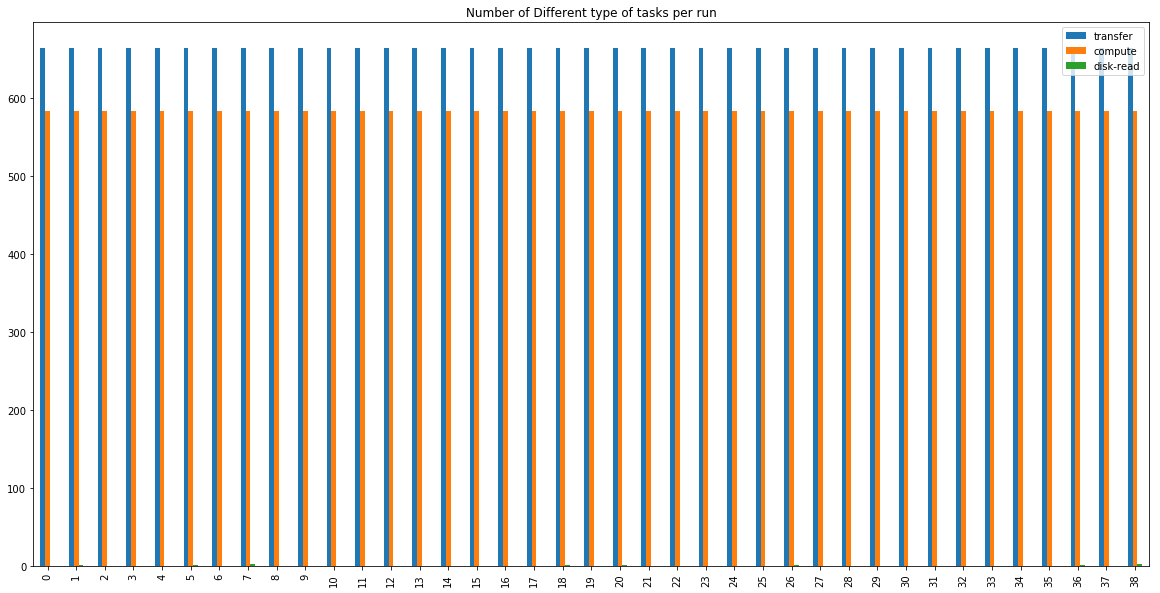

In [7]:
task_types = pd.DataFrame(columns=['transfer','compute','disk-read'])
for i in range(1,40):
    sample = rmsd600everything[rmsd600everything['Run']=='Run %d'%i]
    a = sample['action'].value_counts()
    task_types.loc[len(task_types)] = a.values.tolist() if a.values.size==3 else a.values.tolist()+[0]
task_types.plot(kind='bar',figsize=(20,10),title='Number of Different type of tasks per run')

# Delays between Compute Tasks

In [8]:
delays = list()
for i in range(1,40):
    sample = rmsd600everything[(rmsd600everything['Run']=='Run %d'%i) & (rmsd600everything['action']=='compute')]
    for proc_id in sample['y'].unique():
        proc_tasks = sample[sample['y']==proc_id].reset_index(drop=True)
        times = list()
        for index, row in proc_tasks.iterrows():
            if index ==0:
                start,finish = row['start'],row['start']+row['duration']
            else:
                start = row['start']
                times.append(start - finish)
                finish = row['start']+row['duration']
            
        delays +=times

hist,edges = np.histogram(delays,200)
hist_plot=bplt.figure(height=400,width=700,x_axis_label='Delay between Tasks in msec',title='Block RMSD x600 Dask Task delays between tasks histogram, μ=%f, σ=%f'%(np.mean(delays),np.std(delays)))
hist_plot.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],fill_color="#036564", line_color="#033649")

bplt.show(hist_plot)
print 'Dask Tasks Delays over 2 sigma from the mean: ',np.count_nonzero(np.array(delays)>(np.mean(delays)+2*np.std(delays))),'Total Number: ', len(delays)
        

Dask Tasks Delays over 2 sigma from the mean:  168 Total Number:  17589


# Scheduler Delays

In [9]:
init_sched = list()
for i in range(1,40):
    sample = rmsd600everything[(rmsd600everything['Run']=='Run %d'%i) & (rmsd600everything['name']=='block_rmsd')]
    sample['dt']=sample['start']-sample['start'].min()
    init_sched += sample['dt'].values.tolist()
    
hist,edges = np.histogram(init_sched,500)
hist_plot=bplt.figure(height=600,width=800,x_axis_label='Block RMSD Scheduler Delays in msec',title='Block RMSD Task x600 Dask Scheduler Delay histogram, μ=%f, σ=%f'%(np.mean(init_sched),np.std(init_sched)))
hist_plot.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],fill_color="#036564", line_color="#033649")

bplt.show(hist_plot)
print 'Dask Tasks Scheduler Delays over 2 sigma from the mean: ',np.count_nonzero(np.array(init_sched)>(np.mean(init_sched)+2*np.std(init_sched))),'Total Number: ', len(init_sched)

/Users/iparask/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Dask Tasks Scheduler Delays over 2 sigma from the mean:  131 Total Number:  5616


# Tranfser Times

In [10]:
tranfer_durations = list()
for i in range(1,40):
    sample = rmsd600everything[(rmsd600everything['Run']=='Run %d'%i) & (rmsd600everything['action']=='transfer')]
    tranfer_durations+=sample['duration'].values.tolist()
        
hist,edges = np.histogram(tranfer_durations,500)
hist_plot=bplt.figure(height=600,width=800,x_axis_label='Block RMSD Transfer Durations in msec',title='Block RMSD x600 Dask Transfer Task Durations histogram, μ=%f, σ=%f'%(np.mean(tranfer_durations),np.std(tranfer_durations)))
hist_plot.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],fill_color="#036564", line_color="#033649")

bplt.show(hist_plot)
print 'Dask Tasks Trnasfer Durations over 2 sigma from the mean: ',np.count_nonzero(np.array(tranfer_durations)>(np.mean(init_sched)+2*np.std(tranfer_durations))),'Total Number: ', len(tranfer_durations)

Dask Tasks Trnasfer Durations over 2 sigma from the mean:  0 Total Number:  25896
